# **Credit Card Approval ML Project**


# Credit Card Approval Prediction – Machine Learning Project

This project aims to predict whether a credit card application should be approved or not using machine learning techniques. Based on applicants' personal and financial information, the model classifies individuals as "good" or "bad" clients.

## About the Dataset

The dataset contains two tables that can be merged using the `ID` column:

### 1. `application_record.csv`  
Contains demographic and socio-economic information of applicants.

| Feature | Description |
|--------|-------------|
| ID | Client number |
| CODE_GENDER | Gender |
| FLAG_OWN_CAR | Owns a car |
| FLAG_OWN_REALTY | Owns a property |
| CNT_CHILDREN | Number of children |
| AMT_INCOME_TOTAL | Annual income |
| NAME_INCOME_TYPE | Income type |
| NAME_EDUCATION_TYPE | Education level |
| NAME_FAMILY_STATUS | Marital status |
| NAME_HOUSING_TYPE | Housing type |
| DAYS_BIRTH | Days since birth (negative values) |
| DAYS_EMPLOYED | Days employed (negative values, positive means unemployed) |
| FLAG_MOBIL | Has mobile phone |
| FLAG_WORK_PHONE | Has work phone |
| FLAG_PHONE | Has phone |
| FLAG_EMAIL | Has email |
| OCCUPATION_TYPE | Occupation |
| CNT_FAM_MEMBERS | Number of family members |

### 2. `credit_record.csv`  
Includes the applicants’ monthly credit history.

| Feature | Description |
|--------|-------------|
| ID | Client number |
| MONTHS_BALANCE | Months since the record (0 = current month, -1 = previous, etc.) |
| STATUS | Credit status: |
|        | 0: 1-29 days overdue |
|        | 1: 30-59 days overdue |
|        | 2: 60-89 days overdue |
|        | 3: 90-119 days overdue |
|        | 4: 120-149 days overdue |
|        | 5: 150+ days overdue / bad debt |
|        | C: Paid off that month |
|        | X: No loan for the month |


In [1]:
!pip install imblearn
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 67.7 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


# 1.Dataset Preprocessing

### Application Record Dataset Features

In [3]:
application= pd.read_csv("/kaggle/input/credit-card-approval-prediction/application_record.csv")
application.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [4]:
application.shape

(438557, 18)

In [5]:
application.rename(columns={'CODE_GENDER':'Gender','FLAG_OWN_CAR':'Car','FLAG_OWN_REALTY':'Realty',
                         'CNT_CHILDREN':'Childnmbr','AMT_INCOME_TOTAL':'TotalIncome',
                         'NAME_INCOME_TYPE':'Incometype','NAME_EDUCATION_TYPE':'Edu','NAME_FAMILY_STATUS':'Fam',
                        'NAME_HOUSING_TYPE':'Housing','DAYS_BIRTH':'Birthday', 'DAYS_EMPLOYED':'EmplymntDate',
                        'FLAG_EMAIL':'email','NAME_INCOME_TYPE':'Incometype','FLAG_WORK_PHONE':'workphn',
                         'FLAG_MOBIL':'mobil','FLAG_PHONE':'phone','CNT_FAM_MEMBERS':'famsize',
                        'OCCUPATION_TYPE':'Occupation'
                        },inplace=True)

In [6]:
application.head(3)

,ID,Gender,Car,Realty,Childnmbr,TotalIncome,Incometype,Edu,Fam,Housing,Birthday,EmplymntDate,mobil,workphn,phone,email,Occupation,famsize
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0


A check for missing values should be carried out on this dataset.

In [7]:
application.isnull().sum()

ID                   0
Gender               0
Car                  0
Realty               0
Childnmbr            0
TotalIncome          0
Incometype           0
Edu                  0
Fam                  0
Housing              0
Birthday             0
EmplymntDate         0
mobil                0
workphn              0
phone                0
email                0
Occupation      134203
famsize              0
dtype: int64

As seen above there are null values in the `Occupation` column, so we will drop those rows entirely.

In [8]:
application=application.dropna()

In [9]:
application.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304354 entries, 2 to 438556
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            304354 non-null  int64  
 1   Gender        304354 non-null  object 
 2   Car           304354 non-null  object 
 3   Realty        304354 non-null  object 
 4   Childnmbr     304354 non-null  int64  
 5   TotalIncome   304354 non-null  float64
 6   Incometype    304354 non-null  object 
 7   Edu           304354 non-null  object 
 8   Fam           304354 non-null  object 
 9   Housing       304354 non-null  object 
 10  Birthday      304354 non-null  int64  
 11  EmplymntDate  304354 non-null  int64  
 12  mobil         304354 non-null  int64  
 13  workphn       304354 non-null  int64  
 14  phone         304354 non-null  int64  
 15  email         304354 non-null  int64  
 16  Occupation    304354 non-null  object 
 17  famsize       304354 non-null  float64
dtypes: float6

And a check for duplicated values.

In [10]:
application.duplicated(subset=['ID']).sum()

23

In the `Application` dataset, duplicated ID values can be removed since each ID uniquely represents a customer. However, in the Credit dataset, ID values correspond to the customer's monthly debt repayment status, so duplicates are expected and should not be removed.

In [11]:
application.drop_duplicates(subset=['ID'], inplace=True)


Two new columns, `Age` and `WorkingYears`, were created by transforming the original `DAYS_BIRTH` and `DAYS_EMPLOYED` values into a more interpretable format (in years). To simplify the dataset and improve model training, the original `Birthday` and `EmplymntDate` columns were removed after transformation.


In [12]:
application['Age']=(-application['Birthday']/365).astype(int)

In the `WorkingYears` column (originally `DAYS_EMPLOYED`), negative values represent the number of days a person has been employed, counted backward from today. These values are converted into **years** and cast as **float** for better interpretability. Positive values indicate that the person is currently **not working**; these are labeled as `-1` using Label Encoding to distinguish them clearly from employed individuals.


In [13]:
application["WorkingYears"] = application["EmplymntDate"].apply(lambda x: float(-x / 365) if pd.notnull(x) and x < 0 else -1)

In [14]:
application=application.drop(['Birthday', 'EmplymntDate'], axis=1)


---

### Credit Record Dataset

In [15]:
credit=pd.read_csv("/kaggle/input/credit-card-approval-prediction/credit_record.csv")
credit.head(5)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [16]:
credit['STATUS'].value_counts()

STATUS
C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: count, dtype: int64

The `MONTHS_BALANCE` column indicates the month of each credit record, counted backward from the current month (`0` = current month, `-1` = previous month, etc.). The `STATUS` column shows the payment status and includes values such as `X` (no loan), `C` (paid off), and `0–4` (various levels of overdue payments). For modeling purposes, these values are grouped into two categories: **`good_debt`** (no delay, values `C` and `X`) and **`bad_debt`** (any delay, values `0`, `1`, `2`, `3`, `4`).


In [17]:
credit["STATUS"]=credit["STATUS"].astype(str)
credit['STATUS']=credit['STATUS'].apply(lambda x: "Good_Debt" if x in ["X", "C"] else "Bad_Debt")


In [18]:
credit['STATUS'].value_counts(normalize=True)

STATUS
Good_Debt    0.621091
Bad_Debt     0.378909
Name: proportion, dtype: float64

After changing the variables in the `Status` column integer to categorical values, made a new dataframe with the total counts of status by ID. 

In [19]:
status_counts = credit.groupby("ID")['STATUS'].value_counts().unstack(fill_value=0)


Adding this new dataframe to application dataframe.

In [20]:
df_app=application.set_index("ID").join(status_counts)

In [21]:
df_app.info()
print(df_app.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 304331 entries, 5008806 to 6842885
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Gender        304331 non-null  object 
 1   Car           304331 non-null  object 
 2   Realty        304331 non-null  object 
 3   Childnmbr     304331 non-null  int64  
 4   TotalIncome   304331 non-null  float64
 5   Incometype    304331 non-null  object 
 6   Edu           304331 non-null  object 
 7   Fam           304331 non-null  object 
 8   Housing       304331 non-null  object 
 9   mobil         304331 non-null  int64  
 10  workphn       304331 non-null  int64  
 11  phone         304331 non-null  int64  
 12  email         304331 non-null  int64  
 13  Occupation    304331 non-null  object 
 14  famsize       304331 non-null  float64
 15  Age           304331 non-null  int64  
 16  WorkingYears  304331 non-null  float64
 17  Bad_Debt      25134 non-null   float64
 18  Go

# 2.Dealing with Imbalanced Data

When merging the `Status` DataFrame with the `Application` DataFrame, missing values (NaNs) will appear. This is expected because the `Status` information comes from the `Credit` DataFrame, which only includes historical records of customers who have previously taken out loans. As a result, not all applicants will have corresponding credit history data.

To address this imbalance:

1. **Fill missing values with `0`**, assuming no credit history indicates no debt issues.
2. **Create three classes** based on the `good_debt` and `bad_debt` definitions to better capture different credit behaviors for classification purposes.




In [22]:
df_app[['Good_Debt', 'Bad_Debt']] = df_app[['Good_Debt', 'Bad_Debt']].fillna(0)
((df_app['Good_Debt'] == 0) & (df_app['Bad_Debt'] == 0)).sum()

279197

In [23]:
df_app['debt_status'] = np.where(
    (df_app['Good_Debt'] == 0) & (df_app['Bad_Debt'] == 0), 
    'no_record',  
    np.where(
        df_app['Good_Debt'] > df_app['Bad_Debt'], 
        'good',   
        'bad'))
print(df_app['debt_status'].value_counts())

debt_status
no_record    279197
good          13097
bad           12037
Name: count, dtype: int64


## Encoding Categorical Features

For model training, categorical variables need to be converted into numerical format. To achieve this, we use **Label Encoding**.

First, a copy of the main DataFrame is created to preserve the original data. Then, **LabelEncoder** is applied to all categorical columns **except** the `debt_status` column, which is already the target variable and will be handled separately.


In [24]:
df_encoded=df_app.copy()


In [25]:

categorical_cols = ['Gender', 'Car', 'Realty', 'Incometype', 'Edu', 'Fam', 'Housing', 'Occupation']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le 

In [26]:
df_encoded['debt_status'].value_counts()

debt_status
no_record    279197
good          13097
bad           12037
Name: count, dtype: int64

## SMOTE

We applied `SMOTE` to address severe class imbalance in the dataset (e.g., far fewer *bad/no_record* cases than *good*). Imbalanced data can bias models toward the majority class, leading to poor detection of high-risk cases.

In [27]:
X = df_encoded.drop(['debt_status', 'Good_Debt', 'Bad_Debt'], axis=1)
y = df_encoded['debt_status']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(pd.Series(y_resampled).value_counts())

debt_status
good         279197
bad          279197
no_record    279197
Name: count, dtype: int64


# 3.Modelling

## Model Comparison Summary:

To address the imbalanced credit risk dataset, we evaluated Logistic Regression, KNN, and Random Forest using weighted F1-score and cross-validation. Random Forest outperformed others, thanks to its ability to handle non-linear patterns, feature interactions, and class imbalance via class_weight='balanced'. While slower to train, its robust predictions and interpretability justified the choice.

**Why Random Forest?**
Unlike Logistic Regression’s linear limitations or KNN’s sensitivity to scaling, Random Forest excelled in capturing complex relationships (e.g., Income × Age) and minimizing overfitting. Its superior performance on minority classes (bad/no_record) made it the clear winner for this real-world risk prediction task.


### Splitting data set into train and test sets with resampled data

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, 
    test_size=0.3, 
    random_state=42)

print("Train set:\n", y_train.value_counts())
print("\nTest set:\n", y_test.value_counts())

Train set:
 debt_status
good         195487
no_record    195454
bad          195372
Name: count, dtype: int64

Test set:
 debt_status
bad          83825
no_record    83743
good         83710
Name: count, dtype: int64


### Now we will use Optuna to hyperparameter optimization of Random Forest Classification model.

In [29]:
import optuna
from sklearn.model_selection import cross_val_score
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10)
    }
    model = RandomForestClassifier(**params)
    return cross_val_score(model, X_train, y_train, cv=3, scoring='f1_weighted').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)       

print("Best parameters:", study.best_params)
print("F1 Score:", study.best_value)

[I 2025-05-25 15:08:15,734] A new study created in memory with name: no-name-9e300ea8-bdf7-4330-a9ca-39d06f837490
[I 2025-05-25 15:14:37,460] Trial 0 finished with value: 0.8818728039280508 and parameters: {'n_estimators': 175, 'max_depth': 22, 'min_samples_split': 3}. Best is trial 0 with value: 0.8818728039280508.
[I 2025-05-25 15:15:24,537] Trial 1 finished with value: 0.4050806757004754 and parameters: {'n_estimators': 48, 'max_depth': 5, 'min_samples_split': 3}. Best is trial 0 with value: 0.8818728039280508.
[I 2025-05-25 15:16:03,981] Trial 2 finished with value: 0.5381464268759155 and parameters: {'n_estimators': 24, 'max_depth': 9, 'min_samples_split': 6}. Best is trial 0 with value: 0.8818728039280508.
[I 2025-05-25 15:19:52,193] Trial 3 finished with value: 0.8935700575695608 and parameters: {'n_estimators': 99, 'max_depth': 26, 'min_samples_split': 3}. Best is trial 3 with value: 0.8935700575695608.
[I 2025-05-25 15:22:28,782] Trial 4 finished with value: 0.8823674957918838

Best parameters: {'n_estimators': 127, 'max_depth': 30, 'min_samples_split': 5}
F1 Score: 0.8972594255772446


### **Random Forest Classification Model**

Best parameters for Random Forest Classficiation model according to Optuna:
        -'n_estimators': 127
        -'max_depth': 30
        -'min_samples_split': 5

📊 Classification Report:
              precision    recall  f1-score   support

         bad       0.87      0.86      0.86     83825
        good       0.86      0.87      0.86     83710
   no_record       0.98      0.99      0.98     83743

    accuracy                           0.90    251278
   macro avg       0.90      0.90      0.90    251278
weighted avg       0.90      0.90      0.90    251278



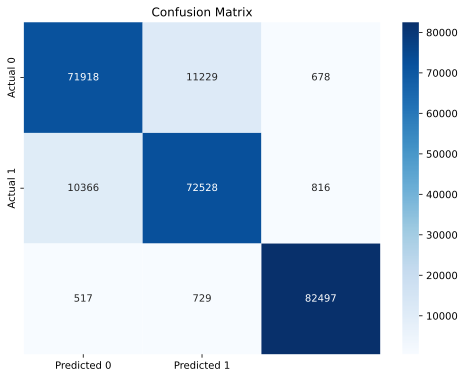

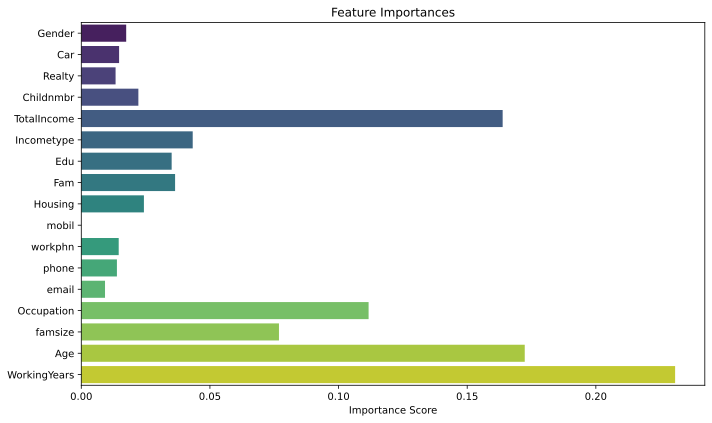

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

#Define the model and train it
rf_model = RandomForestClassifier(
    n_estimators=127,       
    max_depth=30,           
    min_samples_split=5,    
    random_state=42,        
    n_jobs=-1               
)

rf_model.fit(X_train, y_train)

#Prediction on the trained set
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]  

#Performance Metrics
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

#Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.show()

#Importance Score Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=rf_model.feature_importances_, y=X_train.columns, palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()